In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os

In [18]:
!wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/edges2shoes.tar.gz
!tar -xvf edges2shoes.tar.gz

Streaming output truncated to the last 5000 lines.
edges2shoes/train/46382_AB.jpg
edges2shoes/train/46383_AB.jpg
edges2shoes/train/46384_AB.jpg
edges2shoes/train/46385_AB.jpg
edges2shoes/train/46386_AB.jpg
edges2shoes/train/46387_AB.jpg
edges2shoes/train/46388_AB.jpg
edges2shoes/train/46389_AB.jpg
edges2shoes/train/4638_AB.jpg
edges2shoes/train/46390_AB.jpg
edges2shoes/train/46391_AB.jpg
edges2shoes/train/46392_AB.jpg
edges2shoes/train/449_AB.jpg
edges2shoes/train/44_AB.jpg
edges2shoes/train/45000_AB.jpg
edges2shoes/train/45001_AB.jpg
edges2shoes/train/45002_AB.jpg
edges2shoes/train/45003_AB.jpg
edges2shoes/train/45004_AB.jpg
edges2shoes/train/45005_AB.jpg
edges2shoes/train/45006_AB.jpg
edges2shoes/train/45007_AB.jpg
edges2shoes/train/45008_AB.jpg
edges2shoes/train/45009_AB.jpg
edges2shoes/train/4500_AB.jpg
edges2shoes/train/45010_AB.jpg
edges2shoes/train/45011_AB.jpg
edges2shoes/train/45012_AB.jpg
edges2shoes/train/45013_AB.jpg
edges2shoes/train/45687_AB.jpg
edges2shoes/train/45688_AB

In [19]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class Pix2PixDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_files = os.listdir(root_dir)
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root_dir, self.image_files[idx]))
        w, h = img.size

        edge = img.crop((0, 0, w//2, h))
        real = img.crop((w//2, 0, w, h))

        edge = self.transform(edge)
        real = self.transform(real)

        return edge, real

In [28]:
train_dataset = Pix2PixDataset("edges2shoes/train")
train_dataset.image_files = train_dataset.image_files[:2000]
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
transforms.Resize((128,128))

Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=True)

In [29]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        def down(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.LeakyReLU(0.2)
            )

        def up(in_c, out_c):
            return nn.Sequential(
                nn.ConvTranspose2d(in_c, out_c, 4, 2, 1),
                nn.BatchNorm2d(out_c),
                nn.ReLU()
            )

        self.down1 = down(3, 64)
        self.down2 = down(64, 128)
        self.down3 = down(128, 256)
        self.down4 = down(256, 512)

        self.up1 = up(512, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)

        u1 = self.up1(d4)
        u1 = torch.cat([u1, d3], 1)

        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], 1)

        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], 1)

        return self.final(u3)

In [30]:
class PatchDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(6, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 1, 4, 1, 1)
        )

    def forward(self, x, y):
        combined = torch.cat([x, y], dim=1)
        return self.model(combined)

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

G = UNetGenerator().to(device)
D = PatchDiscriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

In [34]:
epochs = 25  # increase to 100+ for better results

for epoch in range(epochs):
    for edge, real in train_loader:

        edge = edge.to(device)
        real = real.to(device)

        # Train D
        fake = G(edge)

        real_pred = D(edge, real)
        fake_pred = D(edge, fake.detach())

        loss_D_real = criterion_GAN(real_pred, torch.ones_like(real_pred))
        loss_D_fake = criterion_GAN(fake_pred, torch.zeros_like(fake_pred))

        loss_D = (loss_D_real + loss_D_fake) / 2

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # Train G
        fake_pred = D(edge, fake)
        loss_G_GAN = criterion_GAN(fake_pred, torch.ones_like(fake_pred))
        loss_G_L1 = criterion_L1(fake, real) * 100

        loss_G = loss_G_GAN + loss_G_L1

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")

Epoch 1/25 | Loss D: 0.2401 | Loss G: 28.9265
Epoch 2/25 | Loss D: 0.3333 | Loss G: 18.7886
Epoch 3/25 | Loss D: 0.1137 | Loss G: 14.7268
Epoch 4/25 | Loss D: 0.2650 | Loss G: 13.3169
Epoch 5/25 | Loss D: 0.1408 | Loss G: 14.7058
Epoch 6/25 | Loss D: 0.1298 | Loss G: 11.9177
Epoch 7/25 | Loss D: 0.3488 | Loss G: 11.4671
Epoch 8/25 | Loss D: 0.1164 | Loss G: 20.8625
Epoch 9/25 | Loss D: 0.1383 | Loss G: 15.3292
Epoch 10/25 | Loss D: 0.0820 | Loss G: 16.3492
Epoch 11/25 | Loss D: 0.0397 | Loss G: 29.3024
Epoch 12/25 | Loss D: 0.0485 | Loss G: 12.5846
Epoch 13/25 | Loss D: 0.2950 | Loss G: 16.5013
Epoch 14/25 | Loss D: 0.2650 | Loss G: 12.0145
Epoch 15/25 | Loss D: 0.2018 | Loss G: 12.6504
Epoch 16/25 | Loss D: 0.0052 | Loss G: 16.1247
Epoch 17/25 | Loss D: 0.0449 | Loss G: 16.5541
Epoch 18/25 | Loss D: 0.0184 | Loss G: 17.2015
Epoch 19/25 | Loss D: 0.2691 | Loss G: 17.4989
Epoch 20/25 | Loss D: 0.1152 | Loss G: 9.6166
Epoch 21/25 | Loss D: 0.5016 | Loss G: 10.6567
Epoch 22/25 | Loss D: 0

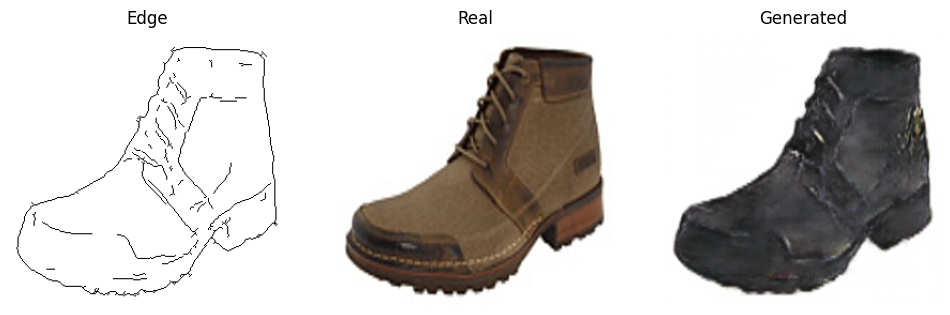

In [40]:
edge, real = next(iter(train_loader))
edge = edge.to(device)

with torch.no_grad():
    fake = G(edge)

def show(img):
    img = img.cpu().detach().numpy()[0]
    img = (img * 0.5) + 0.5
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis("off")

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
show(edge)
plt.title("Edge")

plt.subplot(1,3,2)
show(real)
plt.title("Real")

plt.subplot(1,3,3)
show(fake)
plt.title("Generated")

plt.show()